# Feature Extraction

In [ ]:
import librosa
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from scipy.signal import correlate

folder_path = './songs'
mp3_files = [f for f in os.listdir(folder_path) if f.endswith('.mp3')]
mfccs = []
n_mfcc= 13
for element in mp3_files:
  audio_data, sample_rate = librosa.load(os.path.join(folder_path, element), sr=None)
  mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
  mfccs.append(mfcc)

# Preprocessing

In [ ]:
def pad_features(features, target_length):
    """Pad or truncate features to target length"""
    if features.shape[1] < target_length:
        pad_width = target_length - features.shape[1]
        padded = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
    elif features.shape[1] > target_length:
        padded = features[:, :target_length]
    else:
        padded = features
    return padded

In [ ]:
time_frames = [mfcc.shape[1] for mfcc in mfccs]  # Get the number of time frames for each file
avg_time_frames = int(np.mean(time_frames))  # Calculate the average number of time frames

padded_mfccs = []
for mfcc in mfccs:
    if mfcc.shape[1] < avg_time_frames:
        # Pad with zeros (or another value if desired)
        pad_width = avg_time_frames - mfcc.shape[1]
        padded_mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    elif mfcc.shape[1] > avg_time_frames:
        # Truncate to the average time frames
        padded_mfcc = mfcc[:, :avg_time_frames]
    else:
        padded_mfcc = mfcc
    padded_mfccs.append(padded_mfcc)

padded_mfccs = np.array(padded_mfccs)
mfcc_means = np.mean(padded_mfccs, axis=(0, 2))  # Shape: (n_mfcc,)
mfcc_stds = np.std(padded_mfccs, axis=(0, 2))    # Shape: (n_mfcc,)
proc_mfcc = (padded_mfccs - mfcc_means[:, np.newaxis]) / mfcc_stds[:, np.newaxis]

# TODO: STANDARDIZE DATA
# TODO: Make a github to save the different versions


# Starting Inference

### t-SNE just for me to choose the number of clusters

In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# X = np.array([mfcc.flatten() for mfcc in proc_data])
# tsne = TSNE(n_components=2, perplexity=50, learning_rate=200, random_state=42)
# X_embedded = tsne.fit_transform(X)

# plt.figure(figsize=(8, 6))
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=40, alpha=0.7)
# plt.title("t-SNE projection of MFCC data")
# plt.xlabel("t-SNE 1")
# plt.ylabel("t-SNE 2")
# plt.grid(True)
# plt.show()

I am going to choose 4 genres. In the end I will add a 5th genre which is whethere there is speech or not

## PCA and GMMs for 4 clusters

In [85]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

n_clusters = 4

X = np.array([mfcc.flatten() for mfcc in proc_data])
pca = PCA(n_components=0.9)  # Preserve 90% of the variance
X_pca = pca.fit_transform(X)

print("Original shape:", X.shape)  # (50, 343863)
print("New shape after PCA:", X_pca.shape)  # (50, num_components)

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

Original shape: (200, 369239)
New shape after PCA: (200, 73)


c:\Users\npapaniko\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


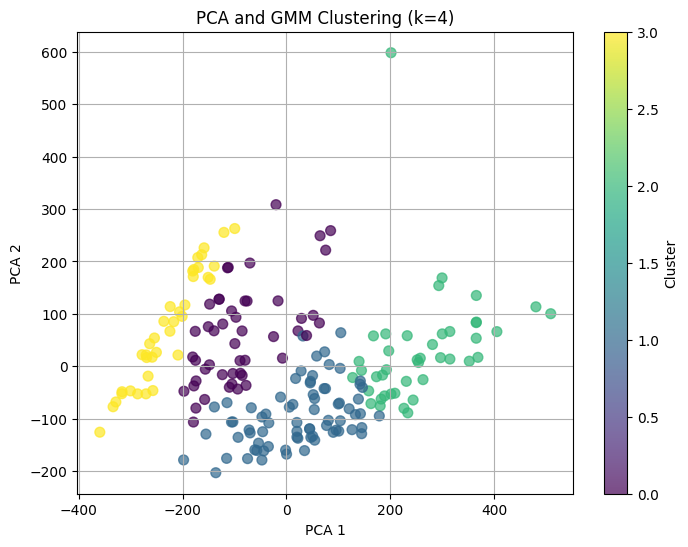

In [86]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("PCA and GMM Clustering (k=4)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


# Check my clustering algorithm

In [87]:
# Step 4: Find indices of songs in each cluster
cluster_indices = {}
for cluster_num in range(n_clusters): 
    files_in_cluster = [mp3_files[i] for i in range(len(gmm_labels)) if gmm_labels[i] == cluster_num]
    cluster_indices[cluster_num] = files_in_cluster

# Step 5: Print the indices for each cluster
for cluster_num, indices in cluster_indices.items():
    print(f"Indices for Cluster {cluster_num}: {indices}")

Indices for Cluster 0: ['Arctic Monkeys - Body Paint Live Performance.mp3', 'Beirut-Spillhaugen.mp3', 'björk ft. rosalía ： oral.mp3', 'Cate Le Bon - You Don’t love me.mp3', 'Earth Wind  Fire - September.mp3', 'Ella Fitzgerald - Summertime live.mp3', 'Enigma - La puerta del cìelo radio edit.mp3', 'Joni Mitchell - Cold Blue Steel and Sweet Fire.mp3', 'Joni Mitchell - For the Roses.mp3', 'Joni Mitchell - Goodbye Blue Sky.mp3', 'Joni Mitchell - Little Green.mp3', 'Joni Mitchell - Lucky Girl.mp3', 'Joni Mitchell - My Old Man.mp3', 'Joni Mitchell - Night Ride Home.mp3', 'Joni Mitchell - River.mp3', 'Kate Bush - Between a Man and a Woman.mp3', 'Kate Bush - Never Be Mine.mp3', 'Kate Bush - Reaching Out.mp3', 'Kate Bush - The Sensual World.mp3', 'Kate Bush - This Womans Work single mix.mp3', 'Kate Bush - Walk Straight Down the Middle.mp3', 'Manos Hatzidakis - Dance with my own shadow -Χορός με τη σκ.mp3', 'Olafur Arnalds - Back To The Sky.mp3', 'Paul Fritz Kalkbrenner - Sky and Sand.mp3', 'Robe

In [95]:
for element in cluster_indices[3]:
  print(element)

100 gecs - 757.mp3
100 gecs - Hand Crushed by a Mallet.mp3
100 gecs - money machine.mp3
Alfa Mist - Stay Here.mp3
Demy - Thelo na me kratas.mp3
Devendra Banhart - Für Hildegard von Bingen.mp3
ELIO - CHARGER ft. Charli XCX.mp3
Joni Mitchell - Big Yellow Taxi.mp3
Joni Mitchell - Blue.mp3
Joni Mitchell - Carey.mp3
Joni Mitchell - Chelsea Morning.mp3
Joni Mitchell - Free Man in Paris.mp3
Joni Mitchell - The same situation.mp3
Jóhann Jóhannsson Air Lyndhurst String Orchestra Anthony Weeden - A Sparrow Alighted Upon Our Shoulder.mp3
Kate Bush - The Morning Fog.mp3
Kath Bloom Loren MazzaCane Connors - Fall Again.mp3
Mitski - Old Friend.mp3
Radiohead - 2  2  5 The Lukewarm.mp3
Ryuichi Sakamoto - Nuages.mp3
Sparklehorse-Saturday.mp3
Takagi Masakatsu - Amamizu.mp3
Takagi Masakatsu - Oo Haru.mp3
Takagi Masakatsu - かみしゃま 1.mp3
Takagi Masakatsu - ももいろのほほ.mp3
Takagi Masakatsu -あまみず.mp3
Takagi Masakatsu -かみしゃま.mp3
Takagi Masakatsu -しらいき.mp3
Takagi Masakatsu -たにのはまべ.mp3
Takagi Masakatsu -ととろきみづ.mp3
Th